# Human Action Classification (MobileNet)

##### Copyright & Acknowledgement

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


Note: This notebook includes code authored by the creators of TensorFlow, as featured in TensorFlow Tutorials. The notebook also includes content taken from UCF101 web page.
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />TensorFlow Tutorials</a>
  </td>
  <td>
    <a target="_blank" href="https://www.crcv.ucf.edu/research/data-sets/ucf101/"><img src="https://diversityjobs.com/attachments/employer/1/611/152/972.gif" />UCF101</a>
  </td>
</table>

## Introduction

This notebook illustrates the process of loading and preparing [AVI](https://en.wikipedia.org/wiki/Audio_Video_Interleave) video data from the [UCF101 human action dataset](https://www.tensorflow.org/datasets/catalog/ucf101). After the data preprocessing phase, it becomes applicable for various tasks such as video classification/recognition, captioning, or clustering. The dataset comprises authentic action videos sourced from YouTube, encompassing 101 categories like playing the cello, brushing teeth, and applying eye makeup.

* Load the data from a zip file.

* Read sequences of frames out of the video files.

* Visualize the video data.

* Wrap the frame-generator [`tf.data.Dataset`](https://www.tensorflow.org/guide/data).
* Train and save a CNN model
* Load the model and conduct inference

## The Dataset

### Overview

UCF101 is an action recognition data set of realistic action videos, collected from YouTube, having 101 action categories. This data set is an extension of UCF50 data set which has 50 action categories.

With 13320 videos from 101 action categories, UCF101 gives the largest diversity in terms of actions and with the presence of large variations in camera motion, object appearance and pose, object scale, viewpoint, cluttered background, illumination conditions, etc, it is the most challenging data set to date. As most of the available action recognition data sets are not realistic and are staged by actors, UCF101 aims to encourage further research into action recognition by learning and exploring new realistic action categories.

Data Set Details

The videos in 101 action categories are grouped into 25 groups, where each group can consist of 4-7 videos of an action. The videos from the same group may share some common features, such as similar background, similar viewpoint, etc.

The action categories can be divided into five types:

    Human-Object Interaction
    Body-Motion Only
    Human-Human Interaction
    Playing Musical Instruments
    Sports

![sample frames](https://www.crcv.ucf.edu/wp-content/uploads/2019/03/UCF101.jpg)

## Setup

We begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [3]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.2-py3-none-any.whl size=7890 sha256=f5db47ca58bf342a7e6161f1a719abe42c5871eedf7e097ed1b9a95996a965d2
  Stored in directory: /root/.cache/pip/wheels/f2/71/f9/c650cc34039d772da8b040ed447b6b5f5de9abc38d88073fa1
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. We will use a subset of these categories in this demo.

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

We create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [6]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [7]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

We begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

We define the `get_class` function that retrieves the class name from a filename. Then, we create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [8]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [9]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Once we have the list of files per class, we can choose how many classes we would like to use and how many videos we would like per class in order to create our dataset.

In [10]:
SELECTED_CLASSES = ['ApplyEyeMakeup', 'ApplyLipstick', 'Basketball', 'Biking', 'Billiards', 'Hammering', 'HorseRiding', 'JugglingBalls', 'PlayingGuitar', 'Typing']
NUM_CLASSES = len(SELECTED_CLASSES)
FILES_PER_CLASS = 50

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


This new function called `select_subset_of_classes` selects a subset of the classes present within the dataset and a particular number of files per class:

In [13]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [14]:
files_subset = select_subset_of_classes(files_for_class, SELECTED_CLASSES, FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Basketball',
 'Biking',
 'Billiards',
 'Hammering',
 'HorseRiding',
 'JugglingBalls',
 'PlayingGuitar',
 'Typing']

We define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [15]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [16]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ucf_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [17]:
print(list(files_for_class.keys())[:10])

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'BasketballDunk', 'Basketball', 'BenchPress']


In [18]:
def download_ucf_101_subset(zip_url, selected_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      selected_classes: Selected classes from dataset.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = selected_classes

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [19]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       SELECTED_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


100%|██████████| 300/300 [03:12<00:00,  1.56it/s]


val :


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


test :


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


After downloading the data, we now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [20]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


We can also preview the directory of data files now.

In [21]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/test
./UCF101_subset/test/Basketball
./UCF101_subset/test/Basketball/v_Basketball_g21_c01.avi
./UCF101_subset/test/Basketball/v_Basketball_g22_c07.avi
./UCF101_subset/test/Basketball/v_Basketball_g09_c02.avi
./UCF101_subset/test/Basketball/v_Basketball_g06_c02.avi
./UCF101_subset/test/Basketball/UCF101
./UCF101_subset/test/Basketball/v_Basketball_g03_c06.avi
./UCF101_subset/test/Basketball/v_Basketball_g07_c04.avi
./UCF101_subset/test/Basketball/v_Basketball_g10_c05.avi
./UCF101_subset/test/Basketball/v_Basketball_g08_c02.avi
./UCF101_subset/test/Basketball/v_Basketball_g06_c04.avi
./UCF101_subset/test/Basketball/v_Basketball_g24_c04.avi
./UCF101_subset/test/PlayingGuitar
./UCF101_subset/test/PlayingGuitar/v_PlayingGuitar_g24_c04.avi
./UCF101_subset/test/PlayingGuitar/v_PlayingGuitar_g23_c01.avi
./UCF101_subset/test/PlayingGuitar/v_PlayingGuitar_g05_c05.avi
./UCF101_subset/test/PlayingGuitar/v_PlayingGuitar_g13_c04.avi
./UCF101_subset/test/PlayingGuitar/

## Create frames from each video file

The `frames_from_video_file` function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file, and returns them as a NumPy `array`.
To reduce memory and computation overhead, choose a **small** number of frames. In addition, pick the **same** number of frames from each video, which makes it easier to work on batches of data.


In [22]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [23]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

Next, we define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [24]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

We test out the `FrameGenerator` object before wrapping it as a TensorFlow Dataset object. Moreover, for the training dataset, ensure you enable training mode so that the data will be shuffled.

In [25]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 7


Finally, we create a TensorFlow data input pipeline. This pipeline that you create from the generator object allows you to feed in data to your deep learning model. In this video pipeline, each element is a single set of frames and its associated label.

In [26]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

Check to see that the labels are shuffled.

In [27]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(6, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(8, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)


In [28]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [29]:
# Create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                        output_signature = output_signature)

In [30]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()
Shape of test set of frames: (10, 224, 224, 3)
Shape of test labels: ()


## Configure the dataset for performance

We use buffered prefetching such that you can yield data from the disk without having I/O become blocking. Two important functions to use while loading data are:

* `Dataset.cache`: keeps the sets of frames in memory after they're loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch`: overlaps data preprocessing and model execution while training.
Refer to [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance) for details.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

To prepare the data to be fed into the model, use batching as shown below. Notice that when working with video data, such as AVI files, the data should be shaped as a five dimensional object. These dimensions are as follows: `[batch_size, number_of_frames, height, width, channels]`. In comparison, an image would have four dimensions: `[batch_size, height, width, channels]`. The image below is an illustration of how the shape of video data is represented.

![Video data shape](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)


In [32]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)
test_ds = test_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of test set of frames: {test_frames.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)
Shape of test set of frames: (2, 10, 224, 224, 3)
Shape of test labels: (2,)


## Model Training

Now that we have created a TensorFlow `Dataset` of video frames with their labels, we can use it with a deep learning model. The following classification model that uses a pre-trained CNN model (MobileNet) and train it to high accuracy.

Other base models can be found in TensorFlow Hub (Kaggle Models) or under `tf.keras.applications` module:
- [Kaggle Models](https://www.kaggle.com/models)
- [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/)

In [33]:
# We will use MobileNet model without its dense layer. We will train the dense layer ourselves.
net = tf.keras.applications.MobileNet(include_top = False)
net.trainable = False

# Create model object
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),     # Rescale RGB values to the range [0, 1]
    tf.keras.layers.TimeDistributed(net),     # Apply the specified neural network (net) to each time step independentl
    tf.keras.layers.Dense(10),                # We have 10 classes, def activation func is linear. to specify -> tf.keras.layers.Dense(10, activation='relu')
    tf.keras.layers.GlobalAveragePooling3D()  # Downsampling before final classification layer
])

#  Configure the model for training. Defines the optimizer, loss function, and evaluation metric(s)
model.compile(optimizer = 'adam',       #  Update the model's weights based on the gradients of the loss function with respect to the weights
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),   # loss function
              metrics=['accuracy'])     # Metric to monitor model's performance during training

# Start the training process
history = model.fit(train_ds,
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/10
150/150 [==============================] - 132s 854ms/step - loss: 1.9727 - accuracy: 0.2967 - val_loss: 1.6055 - val_accuracy: 0.4100
Epoch 2/10
150/150 [==============================] - 136s 908ms/step - loss: 1.1408 - accuracy: 0.5933 - val_loss: 1.1564 - val_accuracy: 0.6000
Epoch 3/10
150/150 [==============================] - 123s 824ms/step - loss: 0.8049 - accuracy: 0.7633 - val_loss: 1.0148 - val_accuracy: 0.6600
Epoch 4/10
150/150 [==============================] - 121s 809ms/step - loss: 0.5867 - accuracy: 0.8133 - val_loss: 0.9640 - val_accuracy: 0.7300
Epoch 5/10
150/150 [==============================] - 127s 852ms/step - loss: 0.4563 - accuracy: 0.8867 - val_loss: 0.7743 - val_accuracy: 0.7200
Epoch 6/10
150/150 [==============================] - 116s 778ms/step - loss: 0.3860 - accuracy: 0.9033 - val_loss: 0.7652 - val_accuracy: 0.7200
Epoch 7/10
150/150 [==============================] - 117s 

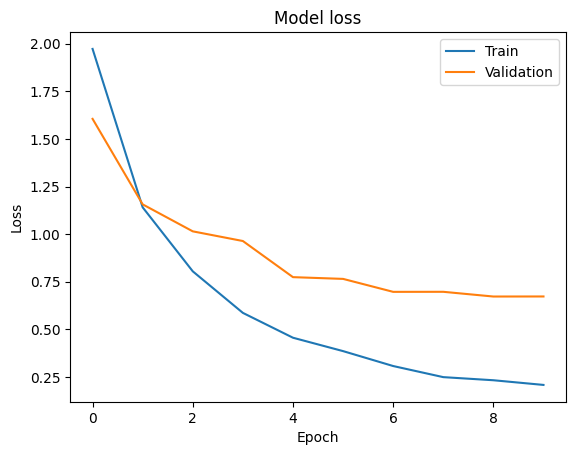

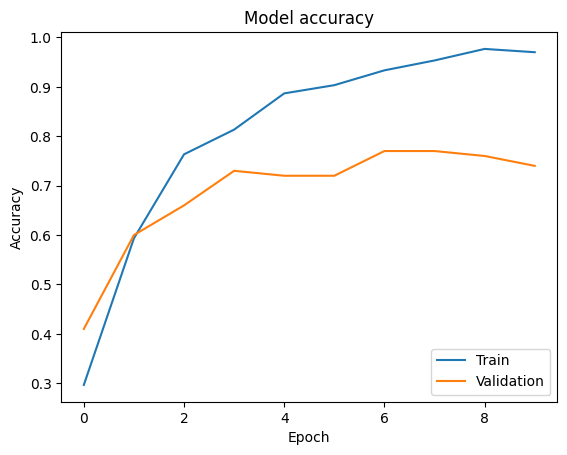

In [34]:
### Plot accuracy & loss vs. iteration
# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [35]:
### Calculate confusion matrix report using test dataset
from sklearn.metrics import confusion_matrix, classification_report
# Step 1: Generate predictions
predictions = model.predict(test_ds)

# Step 2: Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Get true labels from the test dataset
true_labels = np.concatenate([label.numpy() for _, label in test_ds])

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can also print a classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


50/50 [==============================] - 44s 875ms/step
Confusion Matrix:
[[ 6  1  0  0  0  1  0  1  1  0]
 [ 5  4  0  0  0  0  0  1  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  1  8  0  1  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  2  0  0]
 [ 0  0  0  2  0  0  7  1  0  0]
 [ 0  0  0  0  0  0  0  8  2  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  1  0  0  0  0  0  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.80      0.40      0.53        10
           2       0.83      1.00      0.91        10
           3       0.80      0.80      0.80        10
           4       1.00      1.00      1.00        10
           5       0.80      0.80      0.80        10
           6       1.00      0.70      0.82        10
           7       0.62      0.80      0.70        10
           8       0.77      1.00      0.87        10
           9       1.00      0